In [1]:
MEAS_COLUMNS = [
    "TI-19",
#      "FI-16",
#     "TI-33",
#     "FI-2",
#     "FI-151",
#     "TI-8",
#     "FI-241",
#  "valve-position-12",  # dry-bed
#     "FI-38",  # strippera
#     "PI-28",  # stripper
    
#     "TI-28",  # stripper
#      "FI-20",
#     "FI-30",
    "TI-3",
    "FI-19",
#     "FI-211",
    "FI-11",
#     "TI-30",
#     "PI-30",
    "TI-1213",
#     "TI-4",
#    "FI-23",
#    "FI-20",
#   "FI-20/FI-23",
#    "TI-22",
#    "delta_t",
    "TI-35",
#     "delta_t_2"
]

In [2]:
import pandas as pd 
from darts import TimeSeries

In [3]:
from pyprocessta.model.tcn import transform_data, run_model, parallelized_inference
from pyprocessta.preprocess.resample import resample_regular
from darts.dataprocessing.transformers import Scaler
import joblib

import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'

In [4]:
df = pd.read_pickle('20210624_df_cleaned.pkl')
#df = resample_regular(df, '5min')

In [5]:
#df.to_pickle('df_dropped_5min_resampled.pkl')

In [6]:
TARGETS_clean = [
    "2-Amino-2-methylpropanol C4H11NO",
    "Piperazine C4H10N2",
]  # ['Piperazine C4H10N2'] #'2-Amino-2-methylpropanol C4H11NO',


In [7]:
y = TimeSeries.from_dataframe(df, value_cols=TARGETS_clean)
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)

In [8]:
transformer = Scaler()
x = transformer.fit_transform(x)

y_transformer = Scaler()
y = y_transformer.fit_transform(y)

In [9]:
scal = y_transformer.transform(y)

In [10]:
model = run_model(
    (x, y),
    input_chunk_length=80,
    output_chunk_length=5,
    kernel_size=2,
    lr=0.09101,
    n_epochs=400,
    num_filters=32,
    num_layers=8,
    weight_norm=True,
    batch_size=64,
)

/home/kjablonk/anaconda3/envs/timeseries_analysis/lib/python3.8/site-packages/torch/random.py:95: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of GPUs.  If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using.  For example, if you are using CPU only, set CUDA_VISIBLE_DEVICES= or devices=[]; if you are using GPU 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(
[2022-01-19 11:26:28,267] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 5325 samples.
[2022-01-19 11:2

In [11]:
import matplotlib.pyplot as plt

In [11]:
def enable_dropout(model):
    """Function to enable the dropout layers during test-time"""
    for mod in model.children():
        for m2 in mod.children():
            for m3 in m2.children():
                if m3.__class__.__name__.startswith("Dropout"):
                    m3.train()


In [19]:
enable_dropout(model.model)

result = parallelized_inference(model, x, y)

Dropout
Dropout
Dropout
Dropout
Dropout
Dropout
Dropout
Dropout


In [20]:
import numpy as np 

In [21]:
def summarize_results(results): 
    values = []
    
    for df in results: 
        values.append(df.pd_dataframe().values)
    
    df = df.pd_dataframe()
    columns = df.columns
    
    return pd.DataFrame(np.mean(values, axis=0), columns=columns, index=df.index), pd.DataFrame(np.std(values, axis=0), columns=columns,  index=df.index)

In [23]:
means, stds = summarize_results(result)

In [24]:
x_axis = means['0'].index - y[TARGETS_clean[0]].pd_dataframe().index[0]
x_axis = [val.total_seconds() / (60 * 60 * 24) for val in x_axis]

x_conncected = y[TARGETS_clean[0]].pd_dataframe().index - y[TARGETS_clean[0]].pd_dataframe().index[0]
x_conncected = [val.total_seconds() / (60 * 60 * 24) for val in x_conncected]

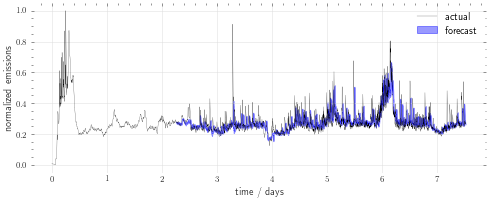

In [25]:
plt.figure(figsize=(7,3))
plt.plot(x_axis, means['0'], c='b',  alpha=.9, lw=.2)
plt.fill_between(x_axis, means['0']-2*stds['0'], means['0']+2*stds['0'], alpha=.4, color='b', label='forecast',)
plt.plot(x_conncected, y[TARGETS_clean[0]].values().flatten(), c='k', label='actual', lw=.2,)

plt.legend()
#plt.xticks([])

plt.xlabel('time / days')
plt.ylabel('normalized emissions')
plt.tight_layout()
plt.savefig(f'20220119_{TARGETS_clean[0]}_forecast_all.pdf', bbox_inches='tight')

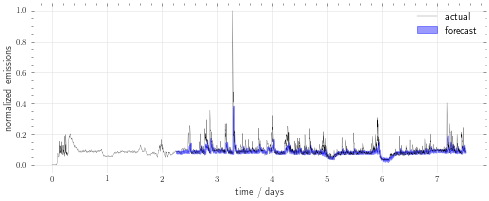

In [26]:
plt.figure(figsize=(7,3))
plt.plot(x_axis, means['1'], c='b',  alpha=.9, lw=.2)
plt.fill_between(x_axis, means['1']-2*stds['1'], means['1']+2*stds['1'], alpha=.4, color='b', label='forecast',)
plt.plot(x_conncected, y[TARGETS_clean[1]].values().flatten(), c='k', label='actual', lw=.2,)

plt.legend()
#plt.xticks([])

plt.xlabel('time / days')
plt.ylabel('normalized emissions')
plt.tight_layout()
plt.savefig(f'20220119_{TARGETS_clean[1]}_forecast_all.pdf', bbox_inches='tight')

In [53]:
# plt.figure(figsize=(7,3))
# plt.plot(x_axis, means['0'], c='b',  alpha=.9, lw=.2)
# plt.fill_between(x_axis, means['0']-2*stds['0'], means['0']+2*stds['0'], alpha=.4, color='b', label='forecast',)
# plt.plot(x_conncected, y['0'].values().flatten(), c='k', label='actual', lw=.2,)

# plt.legend()
# #plt.xticks([])

# plt.xlabel('time / days')
# plt.ylabel('normalized emissions')
# plt.tight_layout()
# plt.savefig('20210814_2_amp_forecast_all.pdf', bbox_inches='tight')

In [27]:
joblib.dump(model, f'20220119_{TARGETS_clean[0]}_model')
joblib.dump(transformer, f'20220119_{TARGETS_clean[0]}_x_scaler')
joblib.dump(y_transformer, f'20220119_{TARGETS_clean[0]}_y_scaler')

['20220119_2-Amino-2-methylpropanol C4H11NO_y_scaler']

transformero build a model for CO2 and NH3

In [31]:
NEW_TARGETS = ["Ammonia NH3", "Carbon dioxide CO2"] #,

In [32]:
y = TimeSeries.from_dataframe(df, value_cols=NEW_TARGETS)
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)

In [33]:
transformer = Scaler()
x = transformer.fit_transform(x)

y_transformer = Scaler()
y = y_transformer.fit_transform(y)

In [34]:
model_co2 = run_model((x,y), output_chunk_length=30)

[2022-01-19 13:10:02,869] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 5320 samples.
[2022-01-19 13:10:02,869] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 5320 samples.
[2022-01-19 13:10:02,891] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-19 13:10:02,891] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


In [36]:
results = parallelized_inference(model_co2, x, y, repeats=100, start=0.1, horizon=30)

In [38]:
means, stds = summarize_results(results)

In [39]:
x_axis = means['0'].index - y[NEW_TARGETS[0]].pd_dataframe().index[0]
x_axis = [val.total_seconds() / (60 * 60 * 24) for val in x_axis]

x_conncected = y[NEW_TARGETS[0]].pd_dataframe().index - y[NEW_TARGETS[0]].pd_dataframe().index[0]
x_conncected = [val.total_seconds() / (60 * 60 * 24) for val in x_conncected]

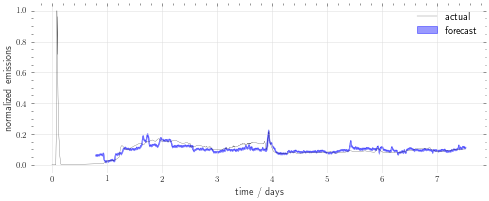

In [40]:
plt.figure(figsize=(7,3))
plt.plot(x_axis, means['0'], c='b',  alpha=.9, lw=.2)
plt.fill_between(x_axis, means['0']-2*stds['0'], means['0']+2*stds['0'], alpha=.4, color='b', label='forecast',)
plt.plot(x_conncected, y[NEW_TARGETS[0]].values().flatten(), c='k', label='actual', lw=.2,)

plt.legend()
#plt.xticks([])

plt.xlabel('time / days')
plt.ylabel('normalized emissions')
plt.tight_layout()
plt.savefig(f'20220119_{NEW_TARGETS[0]}_forecast_all.pdf', bbox_inches='tight')

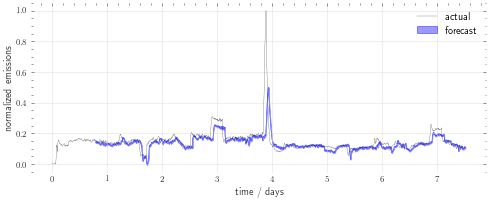

In [42]:
plt.figure(figsize=(7,3))
plt.plot(x_axis, means['1'], c='b',  alpha=.9, lw=.2)
plt.fill_between(x_axis, means['1']-2*stds['1'], means['1']+2*stds['1'], alpha=.4, color='b', label='forecast',)
plt.plot(x_conncected, y[NEW_TARGETS[1]].values().flatten(), c='k', label='actual', lw=.2,)

plt.legend()
#plt.xticks([])

plt.xlabel('time / days')
plt.ylabel('normalized emissions')
plt.tight_layout()
plt.savefig(f'20220119_{NEW_TARGETS[1]}_forecast_all.pdf', bbox_inches='tight')

In [43]:
joblib.dump(model_co2, f'20220119_{NEW_TARGETS[0]}_model')
#joblib.dump(transformer, f'20211229_{NEW_TARGETS[0]}_x_scaler')
joblib.dump(y_transformer, f'20220119_{NEW_TARGETS[0]}_y_scaler')

['20220119_Ammonia NH3_y_scaler']